In [1]:
#General Scenario 2 with Processivity

### Header Files

In [2]:
import xlsxwriter 
import random
import matplotlib.pyplot as plt
import math
import numpy as np
import csv
import queue
from queue import Queue
from numpy.random import permutation
import os

from matplotlib.colors import LogNorm
from PIL import Image, ImageDraw, ImageFont
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from textwrap import wrap
import glob
import pandas as pd
from collections import deque
from timeit import default_timer as timer

from matplotlib.colors import LinearSegmentedColormap
cmap_name = 'my_list'
colors = [(1, 1, 1), (0, 0, 1), (1, 0, 0)]  # White -> Blue -> Red
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=3) 

colors_red = [(1, 1, 1), (1, 0, 0)]  # White -> Red
c_red = LinearSegmentedColormap.from_list(cmap_name, colors_red, N=100) 

colors_blue = [(1, 1, 1), (0, 0, 1)]  # White -> Blue
c_blue = LinearSegmentedColormap.from_list(cmap_name, colors_blue, N=100) 

In [3]:
script_dir = os.getcwd()
graphs_dir = os.path.join(script_dir, 'Reservoir/')

if not os.path.isdir(graphs_dir):
    os.makedirs(graphs_dir)
    
graphs_dir = os.path.join(script_dir, 'Reservoir2/')

if not os.path.isdir(graphs_dir):
    os.makedirs(graphs_dir)
    
graphs_dir = os.path.join(script_dir, 'Particle/')

if not os.path.isdir(graphs_dir):
    os.makedirs(graphs_dir)
    
graphs_dir = os.path.join(script_dir, 'Draw/')

if not os.path.isdir(graphs_dir):
    os.makedirs(graphs_dir)

    
images_dir = os.path.join(script_dir, 'Outputs/')

if not os.path.isdir(images_dir):
    os.makedirs(images_dir)


### Output Files

In [4]:
association_rate = float(input("Enter the association rate: "))
association_rate = association_rate*2

rows_count = 3
cols_count = 1000
cols1 = range(0,1000)
cols2 = range(0,500)
cols3 = range(500,1000)

# Velocity steps:

# Velocity ratio : Va/Vb (Varying it)
vel_a = 5  #1000nm/s 
vel_b = 3  #600nm/s  


#Keeping processivity of A and B same ie Pa/Pb = 1
process_a = 1005   
process_b = 150

#Lifetime
lifetime = 250 #10 secs lifetime

gap = 0
minimum = 0
reservoir_length = 50

total_runtime = 1501 #1 min
time_stamp = 0.04

In [ ]:


workbook = xlsxwriter.Workbook('Scenario 2 Outputs '+ str(association_rate)+'.xlsx')

worksheet = workbook.add_worksheet()              #Outputs
    
worksheet.write(0, 0, "Time")
worksheet.write(0, 1, "Input a")
worksheet.write(0, 2, "Input b")
worksheet.write(0, 3, "Output a")
worksheet.write(0, 4, "Output b")
worksheet.write(0, 5, 'Lateral a')
worksheet.write(0, 6, 'Lateral b')
worksheet.write(0, 7, 'Detach a')
worksheet.write(0, 8, 'Detach b')
worksheet.write(0, 9, 'Reattach a')
worksheet.write(0, 10, 'Reattach b')
worksheet.write(0, 11, "Process Detach a")
worksheet.write(0, 12, "Process Detach b")




### Data Inputs

In [5]:

#Association
motor_cargo_a = 0   #no of a type motor cargos
motor_cargo_b = 0   #no of b type motor cargos
    
#Detachment at the end
throughput_a = 0 #cargo_a output
throughput_b = 0 #cargo_b output
    
lateral_a = 0
lateral_b = 0

#Motors lost due to detachment
detachment_a = [[0 for j in range(cols_count)] for i in range(rows_count)] 
detachment_b = [[0 for j in range(cols_count)] for i in range(rows_count)] 
    
#Motors used due to reattachment
reattachment_a = [[0 for j in range(cols_count)] for i in range(rows_count)] 
reattachment_b = [[0 for j in range(cols_count)] for i in range(rows_count)] 

heat_map_a = [[0 for j in range(cols_count)] for i in range(rows_count)]      
heat_map_b = [[0 for j in range(cols_count)] for i in range(rows_count)]      
heat_map_a_2 = [[0 for j in range(100)] for i in range(rows_count)]      
heat_map_b_2 = [[0 for j in range(100)] for i in range(rows_count)]   
heat_map_a_3 = [[0 for j in range(200)] for i in range(rows_count)]      
heat_map_b_3 = [[0 for j in range(200)] for i in range(rows_count)]

#Motor position and parameters
particle = [[0 for j in range(cols_count)] for i in range(rows_count)]
velocity = [[0 for j in range(cols_count)] for i in range(rows_count)]
span = [[0 for j in range(cols_count)] for i in range(rows_count)]
lifetime_cells = [[0 for j in range(cols_count)] for i in range(rows_count)]

#Productive reservoirs
waiting_a = [[0 for j in range(cols_count)] for i in range(rows_count)] 
waiting_b = [[0 for j in range(cols_count)] for i in range(rows_count)] 

productive_a = [[0 for j in range(cols_count)] for i in range(rows_count)] 
productive_b = [[0 for j in range(cols_count)] for i in range(rows_count)]
#Non-Productive reservoirs
leakage_a = [[0 for j in range(cols_count)] for i in range(rows_count)] 
leakage_b = [[0 for j in range(cols_count)] for i in range(rows_count)] 

non_productive_a = [[0 for j in range(cols_count)] for i in range(rows_count)] 
non_productive_b = [[0 for j in range(cols_count)] for i in range(rows_count)]

wait_a = 0
wait_b = 0
leak_a = 0
leak_b = 0
detach_a = 0
detach_b = 0
reattach_a = 0
reattach_b = 0 
detach_process_a=0
detach_process_b=0



reservoir_a_graph = [[0 for j in range(cols_count)] for i in range(rows_count)]
reservoir_b_graph = [[0 for j in range(cols_count)] for i in range(rows_count)]


In [6]:
class props(object): #detachment time and lifetime
    def __init__(self, joins, life):
        self.joins = joins
        self.life = life
        return
    
reservoir_a = [[0 for j in range(cols_count)] for i in range(rows_count)]
reservoir_b = [[0 for j in range(cols_count)] for i in range(rows_count)]

for i in range(rows_count):
    for j in range(cols_count):
        reservoir_a[i][j] = Queue(maxsize = reservoir_length)
        reservoir_b[i][j] = Queue(maxsize = reservoir_length)
        

### Functions

#### Input Queue

In [7]:

#input
res_in_a_len = int((association_rate*total_runtime)/100)
res_in_b_len = int((association_rate*total_runtime)/100)
res_in_len = total_runtime-(res_in_a_len-res_in_b_len)

res_in_l = []
input_res = Queue(maxsize = total_runtime)
res_in_l = deque(maxlen = total_runtime)


for i in range(res_in_len):
    res_in_l.append(0)
    
for i in range(res_in_a_len):
    res_in_l.append(1)

for i in range(res_in_b_len):
    res_in_l.append(2)
    
random.shuffle(res_in_l)

for i in range(total_runtime):
    input_res.put(res_in_l[i])
    
    

#### Attachment of cargo at the start

In [8]:

def initial_association(particle, velocity, span, lifetime_cells, input_res, motor_cargo_a, motor_cargo_b):
    
    start = timer()
    
    channels = list(range(0,rows_count))        # All channels
    random.shuffle(channels)
    c1 = channels[0]
    channels.remove(channels[0])
    c2 = channels[0]
    channels.remove(channels[0])
    c3 = channels[0]
    
    if(particle[c1][0] == 0):
        particle[c1][0] = input_res.get()
        span[c1][0] = 1
        lifetime_cells[c1][0] = 1
        
        if(particle[c1][0] == 1):
            motor_cargo_a += 1
            velocity[c1][0] = vel_a

        elif(particle[c1][0] == 2):
            motor_cargo_b += 1
            velocity[c1][0] = vel_b
        
    
    elif(particle[c2][0] == 0):
        particle[c2][0] = input_res.get()
        span[c2][0] = 1
        lifetime_cells[c2][0] = 1
        
        if(particle[c2][0] == 1):
            motor_cargo_a += 1
            velocity[c2][0] = vel_a

        elif(particle[c2][0] == 2):
            motor_cargo_b += 1
            velocity[c2][0] = vel_b
    
    elif(particle[c3][0] == 0):
        particle[c3][0] = input_res.get()
        span[c3][0] = 1
        lifetime_cells[c3][0] = 1
        
        if(particle[c3][0] == 1):
            motor_cargo_a += 1
            velocity[c3][0] = vel_a

        elif(particle[c3][0] == 2):
            motor_cargo_b += 1
            velocity[c3][0] = vel_b

    end = timer()
    print("z take", end - start)
    #pdb.set_trace()
    return particle, velocity, span, lifetime_cells, input_res, motor_cargo_a, motor_cargo_b


In [9]:
### Empty the queue with dead reservoirs
def empty_queues(rows_count, cols_count, reservoir_a, reservoir_b, leakage_a, leakage_b, time):
    for i in range(rows_count):
        for j in range(cols_count):
            if(reservoir_a[i][j].qsize() != 0):
                t1 = reservoir_a[i][j].queue[0].joins
                t2 = reservoir_a[i][j].queue[0].life
                if(time-t1+t2 > lifetime):
                    #remove the element as leakage
                    #print("Leak A")
                    reservoir_a[i][j].get()
                    leakage_a[i][j] += 1
                    
            if(reservoir_b[i][j].qsize() != 0):
                t3 = reservoir_b[i][j].queue[0].joins
                t4 = reservoir_b[i][j].queue[0].life
                if(time-t3+t4 > lifetime):
                    #remove the element as leakage
                    #print("Leak B")
                    reservoir_b[i][j].get()
                    leakage_b[i][j] += 1

    return reservoir_a, reservoir_b


#### Lateral Reattachment

In [10]:

def lateral_association(particle, velocity, span, lifetime_cells, rows_count, cols_count, reservoir_a, reservoir_b, reattachment_a, reattachment_b, reattach_a, reattach_b, reattachment_matrix_a, reattachment_matrix_b, leakage_a, leakage_b, time):
    
    start = timer()
    i=0
    j=0
    k=0
    temp = 0
    track = 0
    site = 0
    flag = 0
    flag2 = 0
    step = 0
    step1 = 0
    for i in range(rows_count):
        for j in range(cols_count):
            if(reservoir_a[i][j].qsize() != 0 and reservoir_b[i][j].qsize() == 0):
                flag = 0
            elif(reservoir_a[i][j].qsize() == 0 and reservoir_b[i][j].qsize() != 0):
                flag = 1 
            elif(reservoir_a[i][j].qsize() != 0 and reservoir_b[i][j].qsize() != 0):
                flag = random.randint(0,1)
            else:
                flag = 10
            
            if(flag == 0):
                channels = list(range(0,rows_count))
                channels.remove(i)
                random.shuffle(channels)
                track1 = channels[0]
                track2 = channels[1]
                track = j
                if(j==cols_count):
                    if(particle[i][j] == 0): site = j; track = i; 
                    elif(particle[i][j-1] == 0): site = j-1; track = i; 
                    elif(particle[track1][j] == 0): site = j; track = track1;
                    elif(particle[track1][j-1] == 0): site = j-1; track = track1; 
                    elif(particle[track2][j] == 0): site = j; track = track2; 
                    elif(particle[track2][j-1] == 0): site = j-1; track = track2; 
                    else: continue; 
                else:
                    if(particle[i][j+1] == 0): site = j+1; track = i;
                    elif(particle[track1][j+1] == 0): site = j+1; track = track1; 
                    elif(particle[track2][j+1] == 0): site = j+1; track = track2;
                    elif(particle[i][j] == 0): site = j; track = i;
                    elif(particle[track1][j] == 0): site = j; track = track1; 
                    elif(particle[track2][j] == 0): site = j; track = track2; 
                    elif(particle[i][j-1] == 0): site = j-1; track = i;
                    elif(particle[track1][j-1] == 0): site = j-1; track = track1; 
                    elif(particle[track2][j-1] == 0): site = j-1; track = track2; 
                    else:  continue; 


                particle[track][site] = 1
                velocity[track][site] = vel_a
                span[track][site] = 1

                t = reservoir_a[i][j].get()
                lifetime_cells[i][site] = time-t.joins+t.life
                #print("Reattach A")
                reattachment_a[track][site] += 1
                reattachment_matrix_a[track][site] = 1
                reattach_a += 1

            elif(flag == 1):
                channels = list(range(0,rows_count))
                channels.remove(i)
                random.shuffle(channels)
                track1 = channels[0]
                track2 = channels[1]
                track = j
                if(j==cols_count):
                    if(particle[i][j] == 0): site = j; track = i; 
                    elif(particle[i][j-1] == 0): site = j-1; track = i; 
                    elif(particle[track1][j] == 0): site = j; track = track1;
                    elif(particle[track1][j-1] == 0): site = j-1; track = track1; 
                    elif(particle[track2][j] == 0): site = j; track = track2; 
                    elif(particle[track2][j-1] == 0): site = j-1; track = track2; 
                    else: continue; 
                else:
                    if(particle[i][j+1] == 0): site = j+1; track = i;
                    elif(particle[track1][j+1] == 0): site = j+1; track = track1; 
                    elif(particle[track2][j+1] == 0): site = j+1; track = track2;
                    elif(particle[i][j] == 0): site = j; track = i;
                    elif(particle[track1][j] == 0): site = j; track = track1; 
                    elif(particle[track2][j] == 0): site = j; track = track2; 
                    elif(particle[i][j-1] == 0): site = j-1; track = i;
                    elif(particle[track1][j-1] == 0): site = j-1; track = track1; 
                    elif(particle[track2][j-1] == 0): site = j-1; track = track2; 
                    else:  continue; 

                particle[track][site] = 2
                velocity[track][site] = vel_b
                span[track][site] = 1

                t=reservoir_b[i][j].get()
                lifetime_cells[i][site] = time-t.joins+t.life
                #print("Reattach B")
                reattachment_b[track][site] += 1
                reattachment_matrix_b[track][site] = 1
                reattach_b += 1
            else:
                continue
                
                
    end = timer()
    print("x take", end - start)
    #pdb.set_trace()
    return particle, velocity, span, lifetime_cells, reservoir_a, reservoir_b, reattachment_a, reattachment_b, reattach_a, reattach_b, reattachment_matrix_a, reattachment_matrix_b, leakage_a, leakage_b

#### Transport (Cellular Automata)

In [11]:

def transport(particle, velocity, span, lifetime_cells, rows_count, cols_count, vel_a, vel_b, process_a, process_b, throughput_a, throughput_b, reservoir_a, reservoir_b, detachment_a, detachment_b, detach_a, detach_b, detachment_matrix_a, detachment_matrix_b, leakage_a, leakage_b, lateral_a, lateral_b, detach_process_a, detach_process_b, time):
    start=timer()
    
    for i in range(rows_count):
        gap=0
        minimum=0
        for j in range(cols_count-1,-1,-1):
            if(particle[i][j] == 0):
                gap += 1
                continue
            else:
                #Output
                if(particle[i][j] == 1):
                    if(gap < vel_a):
                        minimum = 0 
                    elif(gap >= vel_a):      
                        minimum = vel_a 
                
                #Constant velocity
                elif(particle[i][j] == 2):
                    if(gap < vel_b):
                        minimum = 0 
                    elif(gap >= vel_b):      
                        minimum = vel_b
                        
                             
                #Movement
                if(minimum > 0):
                    if(particle[i][j] == 1):
                        if((j + vel_a) >= cols_count-1):
                            throughput_a += 1
                            velocity[i][j] = 0
                            particle[i][j] = 0
                            span[i][j] = 0
                            lifetime_cells[i][j] = 0
                        
                        else:
                            velocity[i][j+minimum] = minimum
                            particle[i][j+minimum] = 1
                            span[i][j+minimum] = span[i][j] + minimum
                            lifetime_cells[i][j+minimum] = lifetime_cells[i][j]
                            velocity[i][j] = 0
                            particle[i][j] = 0
                            span[i][j] = 0
                            lifetime_cells[i][j] = 0
                            if(span[i][j+minimum] >= process_a):    
                                #detachment if motor exceeds its processivity
                                velocity[i][j+minimum] = 0
                                particle[i][j+minimum] = 0
                                span[i][j+minimum] = 0
                                print('y1')
                                if(reservoir_a[i][j].qsize()==reservoir_length):
                                    reservoir_a[i][j].get()
                                    leakage_a[i][j] += 1
                                    
                                reservoir_a[i][j].put(props(time,lifetime_cells[i][j+minimum]))
                                
                                lifetime_cells[i][j+minimum]=0
                                detachment_a[i][j+minimum] += 1
                                detachment_matrix_a[i][j+minimum] = 1
                                detach_a += 1
                                detach_process_a += 1

                    elif(particle[i][j] == 2):
                        if((j + vel_b) >= cols_count-1):
                            throughput_b += 1
                            velocity[i][j] = 0
                            particle[i][j] = 0
                            span[i][j] = 0
                            lifetime_cells[i][j] = 0
                        
                        else:
                            velocity[i][j+minimum] = minimum
                            particle[i][j+minimum] = 2
                            span[i][j+minimum] = span[i][j] + minimum
                            lifetime_cells[i][j+minimum] = lifetime_cells[i][j]
                            velocity[i][j] = 0
                            particle[i][j] = 0
                            span[i][j] = 0
                            lifetime_cells[i][j] = 0
                            if(span[i][j+minimum] >= process_b):    
                                #detachment if motor exceeds its processivity
                                velocity[i][j+minimum] = 0
                                particle[i][j+minimum] = 0
                                span[i][j+minimum] = 0
                                print('y2')
                                if(reservoir_b[i][j].qsize()==reservoir_length):
                                    reservoir_b[i][j].get()
                                    leakage_b[i][j] += 1
                                
                                reservoir_b[i][j].put(props(time,lifetime_cells[i][j+minimum]))
                                
                                lifetime_cells[i][j+minimum]=0
                                detachment_b[i][j+minimum] += 1
                                detachment_matrix_b[i][j+minimum] = 1
                                detach_b += 1
                                detach_process_b += 1
                             
                #Detachment         
                elif(minimum == 0):
                    if(particle[i][j] == 1):
                        # Lateral association will happen to only cargos lost at initial stages
                        channels = list(range(0,rows_count))        # All channels
                        channels.remove(i)
                        random.shuffle(channels)
                        y1 = channels[0]
                        channels.remove(channels[0])
                        y2 = channels[0]
            
                        if((j + vel_a) >= cols_count-1):
                            throughput_a += 1
                            velocity[i][j] = 0
                            particle[i][j] = 0
                            span[i][j] = 0
                            lifetime_cells[i][j] = 0
                            
                        else:    
                            velocity[i][j] = 0
                            particle[i][j] = 0
                            span[i][j] = 0
                            print('y3')
                            if(reservoir_a[i][j].qsize()==reservoir_length):
                                reservoir_a[i][j].get()
                                leakage_a[i][j] += 1

                            reservoir_a[i][j].put(props(time,lifetime_cells[i][j]))

                            lifetime_cells[i][j]=0
                            detachment_a[i][j] += 1
                            detachment_matrix_a[i][j] = 1
                            detach_a += 1

                    elif(particle[i][j] == 2):
                        channels = list(range(0,rows_count))        # All channels
                        channels.remove(i)
                        random.shuffle(channels)
                        y1 = channels[0]
                        channels.remove(channels[0])
                        y2 = channels[0]
                        
                        if((j + vel_b) >= cols_count-1):
                            throughput_b += 1
                            velocity[i][j] = 0
                            particle[i][j] = 0
                            span[i][j] = 0
                            lifetime_cells[i][j] = 0
                            
                        else:
                            velocity[i][j] = 0
                            particle[i][j] = 0
                            span[i][j] = 0
                            print('y4')
                            if(reservoir_b[i][j].qsize()==reservoir_length):
                                reservoir_b[i][j].get()
                                leakage_b[i][j] += 1

                            reservoir_b[i][j].put(props(time,lifetime_cells[i][j]))

                            lifetime_cells[i][j]=0
                            detachment_b[i][j] += 1
                            detachment_matrix_b[i][j] = 1
                            detach_b += 1
                
                
                gap = 0
    
    end = timer()
    print("y take", end - start)            
    #pdb.set_trace()
    return particle, velocity, span, lifetime_cells, throughput_a, throughput_b, reservoir_a, reservoir_b, detachment_a, detachment_b, detach_a, detach_b, detachment_matrix_a, detachment_matrix_b, leakage_a, leakage_b, lateral_a, lateral_b, detach_process_a, detach_process_b


### Output / Main Function

z take 3.720000000040358e-05
x take 0.009666399999999964
y take 0.0003508999999999318
0 0
0 0
Done

 Run: 1 0.04884710000000014


<Figure size 432x288 with 0 Axes>

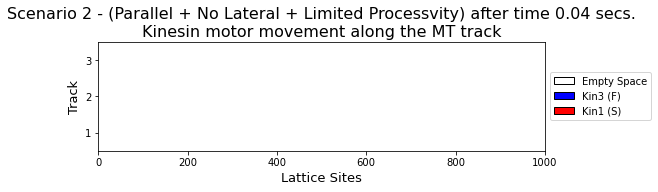

Graph 1 Done


<ipython-input-12-278225d46ceb>:155: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


Graph 1 Done


<ipython-input-12-278225d46ceb>:255: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
<ipython-input-12-278225d46ceb>:255: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


Graph 3 Done
z take 2.6599999999987745e-05
x take 0.0140621000000003
y take 0.0003486999999999796
0 0
0 0
Done

 Run: 2 0.05508279999999921


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

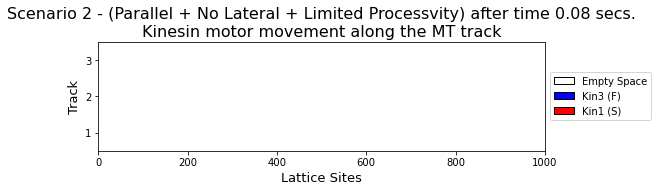

Graph 1 Done
Graph 1 Done
Graph 3 Done
z take 2.7300000000174407e-05
x take 0.010669999999999291
y take 0.0009024000000001919
0 1
0 0
Done

 Run: 3 0.047568100000000335


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

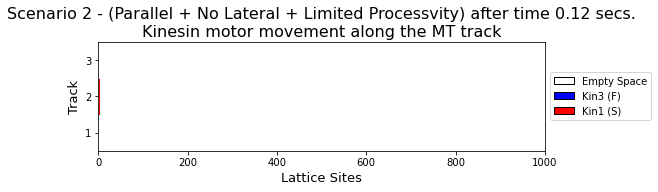

Graph 1 Done
Graph 1 Done
Graph 3 Done
z take 4.350000000030718e-05
x take 0.01043549999999982
y take 0.0004096000000011202
0 2
0 0
Done

 Run: 4 0.0745041999999998


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

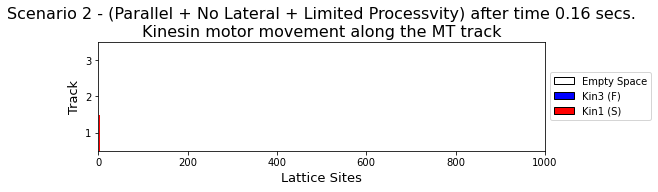

Graph 1 Done
Graph 1 Done


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

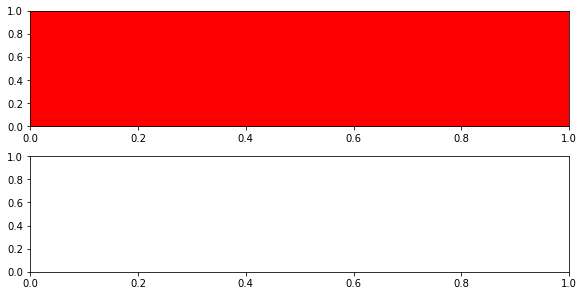

In [12]:

for iter in range(total_runtime):

    start = timer()
    detachment_matrix_a = [[0 for j in range(cols_count)] for i in range(rows_count)] 
    detachment_matrix_b = [[0 for j in range(cols_count)] for i in range(rows_count)]  

    reattachment_matrix_a = [[0 for j in range(cols_count)] for i in range(rows_count)] 
    reattachment_matrix_b = [[0 for j in range(cols_count)] for i in range(rows_count)]

    particle, velocity, span, lifetime_cells, input_res, motor_cargo_a, motor_cargo_b = \
                initial_association(particle, velocity, span, lifetime_cells, input_res, motor_cargo_a, motor_cargo_b)
    
    reservoir_a, reservoir_b = empty_queues(rows_count, cols_count, reservoir_a,\
                               reservoir_b, leakage_a, leakage_b, iter)
        
    particle, velocity, span, lifetime_cells, reservoir_a, reservoir_b, reattachment_a, reattachment_b, reattach_a, reattach_b,\
    reattachment_matrix_a,reattachment_matrix_b,leakage_a, leakage_b = lateral_association(particle, velocity, span, lifetime_cells, \
                                rows_count, cols_count, reservoir_a, reservoir_b, reattachment_a, reattachment_b, reattach_a, \
                                reattach_b, reattachment_matrix_a, reattachment_matrix_b, leakage_a, leakage_b, iter)

    particle, velocity, span, lifetime_cells, throughput_a, throughput_b, reservoir_a, reservoir_b, detachment_a, detachment_b, \
    detach_a, detach_b, detachment_matrix_a, detachment_matrix_b, leakage_a, leakage_b, lateral_a, lateral_b, detach_process_a, \
    detach_process_b = transport(particle, velocity, span, lifetime_cells, rows_count, cols_count, vel_a, vel_b, process_a, \
                                 process_b, throughput_a, throughput_b,reservoir_a, reservoir_b, detachment_a, detachment_b, \
                                 detach_a,detach_b, detachment_matrix_a, detachment_matrix_b, leakage_a, leakage_b, \
                                 lateral_a, lateral_b, detach_process_a, detach_process_b, iter)

    
    print(motor_cargo_a,motor_cargo_b)
    print(throughput_a,throughput_b)
    
    worksheet.write(iter+1, 0, iter+1)
    worksheet.write(iter+1, 1, motor_cargo_a)
    worksheet.write(iter+1, 2, motor_cargo_b)
    worksheet.write(iter+1, 3, throughput_a)
    worksheet.write(iter+1, 4, throughput_b)
    worksheet.write(iter+1, 5, lateral_a)
    worksheet.write(iter+1, 6, lateral_b)
    worksheet.write(iter+1, 7, detach_a)
    worksheet.write(iter+1, 8, detach_b)
    worksheet.write(iter+1, 9, reattach_a)
    worksheet.write(iter+1, 10, reattach_b)
    worksheet.write(iter+1, 11, detach_process_a)
    worksheet.write(iter+1, 12, detach_process_b)

    waiting_a = [[0 for j in range(cols_count)] for i in range(rows_count)] 
    waiting_b = [[0 for j in range(cols_count)] for i in range(rows_count)] 
    wait_a = 0
    wait_b = 0
    leak_a = 0
    leak_b = 0
    
    for i in range(rows_count):
        for j in range(cols_count):
            waiting_a[i][j] = reservoir_a[i][j].qsize()
            waiting_b[i][j] = reservoir_b[i][j].qsize()
            productive_a[i][j] += waiting_a[i][j]
            productive_b[i][j] += waiting_b[i][j]
            non_productive_a[i][j] += leakage_a[i][j]
            non_productive_b[i][j] += leakage_b[i][j]
            wait_a += waiting_a[i][j]
            wait_b += waiting_b[i][j]
            reservoir_a_graph[i][j] += waiting_a[i][j]
            reservoir_b_graph[i][j] += waiting_b[i][j]
            leak_a += leakage_a[i][j]
            leak_b += leakage_b[i][j]
    
    d_a = [0 for j in range(cols_count)]
    d_b = [0 for j in range(cols_count)] 
    r_a = [0 for j in range(cols_count)]
    r_b = [0 for j in range(cols_count)]
    w_a = [0 for j in range(cols_count)]
    w_b = [0 for j in range(cols_count)]
    l_a = [0 for j in range(cols_count)]
    l_b = [0 for j in range(cols_count)] 
    
    for j in range(cols_count):
        for i in range(rows_count):
            d_a[j] += detachment_a[i][j]
            d_b[j] += detachment_b[i][j]
            r_a[j] += reattachment_a[i][j]
            r_b[j] += reattachment_b[i][j]
            w_a[j] += reservoir_a[i][j].qsize()
            w_b[j] += reservoir_b[i][j].qsize()
            l_a[j] += leakage_a[i][j]
            l_b[j] += leakage_b[i][j]
    
    for j in range(cols_count):
        d_a[j] = d_a[j]/total_runtime
        d_b[j] = d_b[j]/total_runtime
        r_a[j] = r_a[j]/total_runtime
        r_b[j] = r_b[j]/total_runtime
            
    print("Done")
    #column9 = "Site, Waiting A Track 1, Waiting B Track 1, Waiting A Track 2, Waiting B Track 2, Leakage A Track 1, Leakage B Track 1, Leakage A Track 2, Leakage B Track 2"
    
    for i in range(rows_count):
        for j in range(cols_count):
            temp = int(j/10)
            temp1 = int(j/5)
            if(particle[i][j] == 1):
                heat_map_a[i][j] += particle[i][j]
                heat_map_a_2[i][temp] += particle[i][j]
                heat_map_a_3[i][temp1] += particle[i][j]
            elif(particle[i][j] == 2):
                heat_map_b[i][j] += particle[i][j]
                heat_map_b_2[i][temp] += particle[i][j]
                heat_map_b_3[i][temp1] += particle[i][j]
                
    
    end = timer()
    print("\n Run: "+ str(iter+1), (end - start))
    
    t = str(iter+1).zfill(5)
    plt.figure(0)
    plt.figure(figsize=(8,2))
    time=(iter+1)*time_stamp
    temp=particle[0][0]
    particle[0][0] = 2
    c0 = plt.pcolor(particle, linewidths = 0.5, cmap=cm)
    plt.xlabel('Lattice Sites', fontsize=13)
    plt.ylabel('Track', fontsize=13)
    custom_lines = [Patch(facecolor='white', edgecolor='k',label='Empty Space'),
                    Patch(facecolor='blue', edgecolor='k',label='Kin3 (F)'),
                    Patch(facecolor='red', edgecolor='k',label='Kin1 (S)')]
    plt.legend(handles=custom_lines,loc='center left', bbox_to_anchor=(1, 0.5))
    plt.yticks([0.5, 1.5, 2.5], ['1', '2', '3'])
    plt.title("\n".join(wrap("Scenario 2 - (Parallel) after time %0.2f"%round(time,2) + " secs." + " Kinesin motor movement along the MT track", 70)), fontsize=16)
    plt.savefig('Particle/Particle_' + t + '.png',  dpi=100, bbox_inches = 'tight')
    plt.draw()
    #plt.show()
    plt.close()
    print("Graph 1 Done")

    particle[0][0] = temp

    ####################################################################################################        

    plt.figure(1)
    fig, axis = plt.subplots(ncols=1, nrows = 3, figsize=(8,6), constrained_layout=True)

    time=(iter+1)*time_stamp
    temp=particle[0][0]
    particle[0][0] = 2
    c0 = axis[0].pcolor(particle, linewidths = 0.5, cmap=cm)
    axis[0].set_xlabel('Lattice Sites', fontsize=13)
    axis[0].set_ylabel('Track', fontsize=13)
    custom_lines = [Patch(facecolor='white', edgecolor='k',label='Empty Space'),
                    Patch(facecolor='blue', edgecolor='k',label='Kin3 (F)'),
                    Patch(facecolor='red', edgecolor='k',label='Kin1 (S)')]
    axis[0].legend(handles=custom_lines,loc='center left', bbox_to_anchor=(1, 0.5))
    axis[0].set_yticks([0.5, 1.5, 2.5])
    axis[0].set_yticklabels(['1', '2', '3'])
    particle[0][0] = temp
    axis[0].set_title("\n".join(wrap('Dynamics of motor movement along the MT track', 60)), fontsize=14)

    temp=reservoir_a_graph[0][0]
    reservoir_a_graph[0][0] = 1        
    c2 = axis[1].pcolor(reservoir_a_graph, linewidths = 0.3, cmap=c_blue)
    axis[1].set_xlabel('Corresponding Lattice Site', fontsize=13)
    axis[1].set_ylabel('Track', fontsize=13)
    axis[1].set_title("\n".join(wrap('Cumulative Productive reservoir detachment dynamics of Kin3 (F)', 70)), fontsize=14)
    axis[1].set_yticks([0.5, 1.5, 2.5])
    axis[1].set_yticklabels(['1', '2', '3'])
    reservoir_a_graph[0][0] = temp  

    temp=reservoir_b_graph[0][0]
    reservoir_b_graph[0][0] = 1   
    c3 = axis[2].pcolor(reservoir_b_graph, linewidths = 0.3, cmap=c_red)
    axis[2].set_xlabel('Corresponding Lattice Site', fontsize=13)
    axis[2].set_ylabel('Track', fontsize=13)
    axis[2].set_title("\n".join(wrap('Cumulative Productive reservoir detachment dynamic of Kin1 (S)', 70)), fontsize=14)
    axis[2].set_yticks([0.5, 1.5, 2.5])
    axis[2].set_yticklabels(['1', '2', '3'])
    reservoir_b_graph[0][0] = temp

#     cax1 = fig.add_axes([axis[1].get_position().x1-0.001,axis[1].get_position().y0,0.02,axis[1].get_position().y1-axis[1].get_position().y0])
#     cax2 = fig.add_axes([axis[2].get_position().x1-0.001,axis[2].get_position().y0-0.03,0.02,axis[2].get_position().y1-axis[2].get_position().y0])

    cax1 = fig.add_axes([axis[1].get_position().x1-0.05,axis[1].get_position().y0,0.02,axis[1].get_position().y1-axis[1].get_position().y0-0.05])
    cax2 = fig.add_axes([axis[2].get_position().x1-0.05,axis[2].get_position().y0-0.04,0.02,axis[2].get_position().y1-axis[2].get_position().y0-0.05])

    fig.colorbar(c2, cax=cax1)
    fig.colorbar(c3, cax=cax2)
    fig.tight_layout()
    fig.suptitle("\n".join(wrap("Scenario 2 - (Parallel) after time %0.2f"%round(time,2) + ' secs', 100)), fontsize=16)
    plt.subplots_adjust(top=0.85, hspace=0.8)
    plt.gcf()
    plt.savefig('Reservoir/Particle_' + t + '.png',  dpi=100, bbox_inches = 'tight')
    plt.draw()
    #plt.show()
    plt.close()
    print("Graph 2 Done")

    
    ####################################################################################################
    
    plt.figure(4)
    fig, axis = plt.subplots(ncols=1, nrows = 2, figsize=(8,4), constrained_layout=True)

    time=(iter+1)*time_stamp
    
    temp=reservoir_a_graph[0][0]
    reservoir_a_graph[0][0] = 1        
    c2 = axis[0].pcolor(reservoir_a_graph, linewidths = 0.3, cmap=c_blue)
    axis[0].set_xlabel('Corresponding Lattice Site', fontsize=13)
    axis[0].set_ylabel('Track', fontsize=13)
    axis[0].set_title("\n".join(wrap('Cumulative Productive reservoir detachment dynamics of Kin3 (F)', 70)), fontsize=14)
    axis[0].set_yticks([0.5, 1.5, 2.5])
    axis[0].set_yticklabels(['1', '2', '3'])
    reservoir_a_graph[0][0] = temp  

    temp=reservoir_b_graph[0][0]
    reservoir_b_graph[0][0] = 1   
    c3 = axis[1].pcolor(reservoir_b_graph, linewidths = 0.3, cmap=c_red)
    axis[1].set_xlabel('Corresponding Lattice Site', fontsize=13)
    axis[1].set_ylabel('Track', fontsize=13)
    axis[1].set_title("\n".join(wrap('Cumulative Productive reservoir detachment dynamic of Kin1 (S)', 70)), fontsize=14)
    axis[1].set_yticks([0.5, 1.5, 2.5])
    axis[1].set_yticklabels(['1', '2', '3'])
    reservoir_b_graph[0][0] = temp

    cax1 = fig.add_axes([axis[0].get_position().x1+0.1,axis[0].get_position().y0,0.02,axis[0].get_position().y1-axis[0].get_position().y0])
    cax2 = fig.add_axes([axis[1].get_position().x1+0.1,axis[1].get_position().y0-0.04,0.02,axis[1].get_position().y1-axis[1].get_position().y0])

    fig.colorbar(c2, cax=cax1)
    fig.colorbar(c3, cax=cax2)
    fig.tight_layout()
    fig.suptitle("\n".join(wrap("Scenario 2 - (Parallel) after time %0.2f"%round(time,2) + ' secs', 100)), fontsize=16)
    plt.subplots_adjust(top=0.85, hspace=0.8)
    plt.gcf()
    plt.savefig('Reservoir2/Particle_' + t + '.png',  dpi=100, bbox_inches = 'tight')
    plt.draw()
    #plt.show()
    plt.close()
    print("Graph 5 Done")
    
    ####################################################################################################
    
    plt.figure(5)
    fig, (ax2, ax3) = plt.subplots(ncols=1, nrows = 2, figsize=(8,5.5), 
                   gridspec_kw={"height_ratios":[1,1]})

    ax2.plot(cols1, d_a, alpha=0.6, color="Blue", label="Kin3 (F)")
    ax2.plot(cols1, d_b, alpha=0.5, color="Red", label="Kin1 (S)")
    ax2.set_ylim(bottom=0)
    ax2.set_xlabel('Corresponding Lattice Site', fontsize=13)
    ax2.set_ylabel("\n".join(wrap('No of Motors', 12)), fontsize=13)
    ax2.set_title("\n".join(wrap('Motor detached into reservoir from lattice site', 60)), fontsize=14)
    ax2.legend(loc="upper right")

    ax3.plot(cols1, r_a, alpha=0.6, color="Blue", label="Kin3 (F)")
    ax3.plot(cols1, r_b, alpha=0.5, color="Red", label="Kin1 (S)")
    ax3.set_ylim(bottom=0)
    ax3.set_xlabel('Corresponding Lattice Site', fontsize=13)
    ax3.set_ylabel("\n".join(wrap('No of Motors', 12)), fontsize=13)
    ax3.set_title("\n".join(wrap('Motor reattached from reservoir into lattice site', 60)), fontsize=14)
    ax3.legend(loc="upper right")

    fig.suptitle("\n".join(wrap('Scenario 2 - (Parallel) after time %0.2f'%round(time,2) + ' secs', 60)), fontsize=16)
    fig.tight_layout()
    plt.subplots_adjust(top=0.8, hspace = 0.7)
    plt.gcf()
    plt.savefig('Draw/Productive_'+t+'.png',  dpi=100, bbox_inches = 'tight')
    #plt.show()
    plt.close()
    print("Graph 6 Done")
        
workbook.close()

In [ ]:
time=(total_runtime)*time_stamp
plt.figure(5)
fig, (ax2, ax3) = plt.subplots(ncols=1, nrows = 2, figsize=(8,5.5), 
               gridspec_kw={"height_ratios":[1,1]})

ax2.plot(cols1, d_a, alpha=0.6, color="Blue", label="Kin3 (F)")
ax2.plot(cols1, d_b, alpha=0.5, color="Red", label="Kin1 (S)")
ax2.set_ylim(bottom=0)
ax2.set_xlabel('Corresponding Lattice Site', fontsize=13)
ax2.set_ylabel("\n".join(wrap('No of Motors', 12)), fontsize=13)
ax2.set_title("\n".join(wrap('Motor detached into reservoir from lattice site', 60)), fontsize=14)
ax2.legend(loc="upper right")

ax3.plot(cols1, r_a, alpha=0.6, color="Blue", label="Kin3 (F)")
ax3.plot(cols1, r_b, alpha=0.5, color="Red", label="Kin1 (S)")
ax3.set_ylim(bottom=0)
ax3.set_xlabel('Corresponding Lattice Site', fontsize=13)
ax3.set_ylabel("\n".join(wrap('No of Motors', 12)), fontsize=13)
ax3.set_title("\n".join(wrap('Motor reattached from reservoir into lattice site', 60)), fontsize=14)
ax3.legend(loc="upper right")

fig.suptitle("\n".join(wrap('Scenario 2 - (Parallel) after time %0.2f'%round(time,2) + ' secs', 60)), fontsize=16)
fig.tight_layout()
plt.subplots_adjust(top=0.8, hspace = 0.7)
plt.gcf()
plt.savefig('Outputs/Productive.png',  dpi=100, bbox_inches = 'tight')
#plt.show()
plt.close()
print("Graph 6 Done")

In [ ]:
fig, axis = plt.subplots(ncols=1, nrows=2,figsize=(8,4), 
                   gridspec_kw={"height_ratios":[1,1], "width_ratios":[1]})
axis = axis.flatten()

top = max(max(max(heat_map_a_3)),max(max(heat_map_b_3)));

time = (total_runtime-1)*time_stamp
c0 = axis[0].pcolor(heat_map_a_3, linewidths = 0.02, cmap=c_blue , vmin=0 , vmax=top)
axis[0].set_title("Kin3 (F)", fontsize=12)
axis[0].set_ylabel('Track')
axis[0].set_yticks([0.5, 1.5, 2.5])
axis[0].set_yticklabels(['1', '2', '3'])

c1 = axis[1].pcolor(heat_map_b_3, linewidths = 0.02, cmap=c_red , vmin=0 , vmax=top)
axis[1].set_title("Kin1 (S)", fontsize=12)
axis[1].set_ylabel('Track')
axis[1].set_xlabel('Sites')
axis[1].set_yticks([0.5, 1.5, 2.5])
axis[1].set_yticklabels(['1', '2', '3'])

cax1 = fig.add_axes([axis[0].get_position().x1+0.1,axis[0].get_position().y0+0.04,0.02,axis[0].get_position().y1-axis[0].get_position().y0])
cax2 = fig.add_axes([axis[1].get_position().x1+0.1,axis[1].get_position().y0,0.02,axis[1].get_position().y1-axis[1].get_position().y0])

fig.colorbar(c0, cax=cax1)
fig.colorbar(c1, cax=cax2)

plt.setp(axis[0], xticks=[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200], 
         xticklabels=['0','100','200','300','400','500','600','700','800','900','1000'],  
         yticks=[0.5, 1.5, 2.5], yticklabels=['1', '2', '3'])
plt.setp(axis[1], xticks=[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200], 
         xticklabels=['0','100','200','300','400','500','600','700','800','900','1000'],  
         yticks=[0.5, 1.5, 2.5], yticklabels=['1', '2', '3'])

fig.suptitle("\n".join(wrap("Distribution of motors along the MT in Scenario 2 - (Parallel) after %0.2f"%time + ' secs', 100)), fontsize=14, y=1.1)
fig.tight_layout()
plt.subplots_adjust(top=0.9)
plt.draw()
plt.savefig('Outputs/Scenario 2 RB Heatmap (by 5).png', format='png', dpi=600, bbox_inches = 'tight')

plt.close()

###########################################################################################################################

fig, axis = plt.subplots(ncols=1, nrows=2,figsize=(8,4), 
                   gridspec_kw={"height_ratios":[1,1], "width_ratios":[1]})
axis = axis.flatten()

top = max(max(max(heat_map_a_2)),max(max(heat_map_b_2)));

time = (total_runtime-1)*time_stamp
c0 = axis[0].pcolor(heat_map_a_2, linewidths = 0.02, cmap=c_blue , vmin=0 , vmax=top)
axis[0].set_title("Kin3 (F)", fontsize=12)
axis[0].set_ylabel('Track')
axis[0].set_yticks([0.5, 1.5, 2.5])
axis[0].set_yticklabels(['1', '2', '3'])

c1 = axis[1].pcolor(heat_map_b_2, linewidths = 0.02, cmap=c_red , vmin=0 , vmax=top)
axis[1].set_title("Kin1 (S)", fontsize=12)
axis[1].set_ylabel('Track')
axis[1].set_xlabel('Sites')
axis[1].set_yticks([0.5, 1.5, 2.5])
axis[1].set_yticklabels(['1', '2', '3'])

cax1 = fig.add_axes([axis[0].get_position().x1+0.1,axis[0].get_position().y0+0.04,0.02,axis[0].get_position().y1-axis[0].get_position().y0])
cax2 = fig.add_axes([axis[1].get_position().x1+0.1,axis[1].get_position().y0,0.02,axis[1].get_position().y1-axis[1].get_position().y0])

fig.colorbar(c0, cax=cax1)
fig.colorbar(c1, cax=cax2)

plt.setp(axis[0], xticks=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
         xticklabels=['0','100','200','300','400','500','600','700','800','900','1000'],  
         yticks=[0.5, 1.5, 2.5], yticklabels=['1', '2', '3'])
plt.setp(axis[1], xticks=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
         xticklabels=['0','100','200','300','400','500','600','700','800','900','1000'],  
         yticks=[0.5, 1.5, 2.5], yticklabels=['1', '2', '3'])

fig.suptitle("\n".join(wrap("Distribution of motors along the MT in Scenario 2 - (Parallel) after %0.2f"%time + ' secs', 100)), fontsize=14, y=1.1)
fig.tight_layout()
plt.subplots_adjust(top=0.9)
plt.draw()
plt.savefig('Outputs/Scenario 2 RB Heatmap (by 10).png', format='png', dpi=600, bbox_inches = 'tight')

plt.close()

###########################################################################################################################

fig, axis = plt.subplots(ncols=1, nrows=2,figsize=(8,4), 
                   gridspec_kw={"height_ratios":[1,1], "width_ratios":[1]})
axis = axis.flatten()

top = max(max(max(heat_map_a)),max(max(heat_map_b)));

time = (total_runtime-1)*time_stamp
c0 = axis[0].pcolor(heat_map_a, linewidths = 0.02, cmap=c_blue , vmin=0 , vmax=top)
axis[0].set_title("Kin3 (F)", fontsize=12)
axis[0].set_ylabel('Track')
axis[0].set_yticks([0.5, 1.5, 2.5])
axis[0].set_yticklabels(['1', '2', '3'])

c1 = axis[1].pcolor(heat_map_b, linewidths = 0.02, cmap=c_red , vmin=0 , vmax=top)
axis[1].set_title("Kin1 (S)", fontsize=12)
axis[1].set_ylabel('Track')
axis[1].set_xlabel('Sites')
axis[1].set_yticks([0.5, 1.5, 2.5])
axis[1].set_yticklabels(['1', '2', '3'])

cax1 = fig.add_axes([axis[0].get_position().x1+0.1,axis[0].get_position().y0+0.04,0.02,axis[0].get_position().y1-axis[0].get_position().y0])
cax2 = fig.add_axes([axis[1].get_position().x1+0.1,axis[1].get_position().y0,0.02,axis[1].get_position().y1-axis[1].get_position().y0])

fig.colorbar(c0, cax=cax1)
fig.colorbar(c1, cax=cax2)

plt.setp(axis[0], yticks=[0.5, 1.5, 2.5], yticklabels=['1', '2', '3'])
plt.setp(axis[1], yticks=[0.5, 1.5, 2.5], yticklabels=['1', '2', '3'])

fig.suptitle("\n".join(wrap("Distribution of motors along the MT in Scenario 2 - (Parallel) after %0.2f"%time + ' secs', 100)), fontsize=14, y=1.1)
fig.tight_layout()
plt.subplots_adjust(top=0.9)
plt.draw()
plt.savefig('Outputs/Scenario 2 RB Heatmap (1).png', format='png', dpi=600, bbox_inches = 'tight')

plt.close()


print("Heatmap Graph Done")

In [ ]:
# filepaths
fp_in = "Particle/Particle_*.png"
fp_out = "Outputs/Scenario 2 Motor.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=200, loop=0)

# filepaths
fp_in = "Reservoir/Particle_*.png"
fp_out = "Outputs/Scenario 2 Motor + Reservoir.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=200, loop=0)

# filepaths
fp_in = "Reservoir2/Particle_*.png"
fp_out = "Outputs/Scenario 2 Reservoir.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=200, loop=0)

# filepaths
fp_in = "Draw/Particle_*.png"
fp_out = "Outputs/Scenario 2 Waiting (Fast).gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=200, loop=0)

